In [ ]:
!pip install -q tensorflow tensorflow-datasets

### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
tfds.disable_progress_bar()

### Datasets

In [ ]:
# https://www.tensorflow.org/datasets/overview
# https://www.tensorflow.org/datasets/catalog/overview
tfds.list_builders()[0:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence']

In [ ]:
builder = tfds.builder('rock_paper_scissors')
info = builder.info

info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path=PosixGPath('/tmp/tmp2iffuuxdtfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

### Loading Data

In [ ]:
ds_train = tfds.load(name="rock_paper_scissors", split="train")
ds_test = tfds.load(name="rock_paper_scissors", split="test")

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


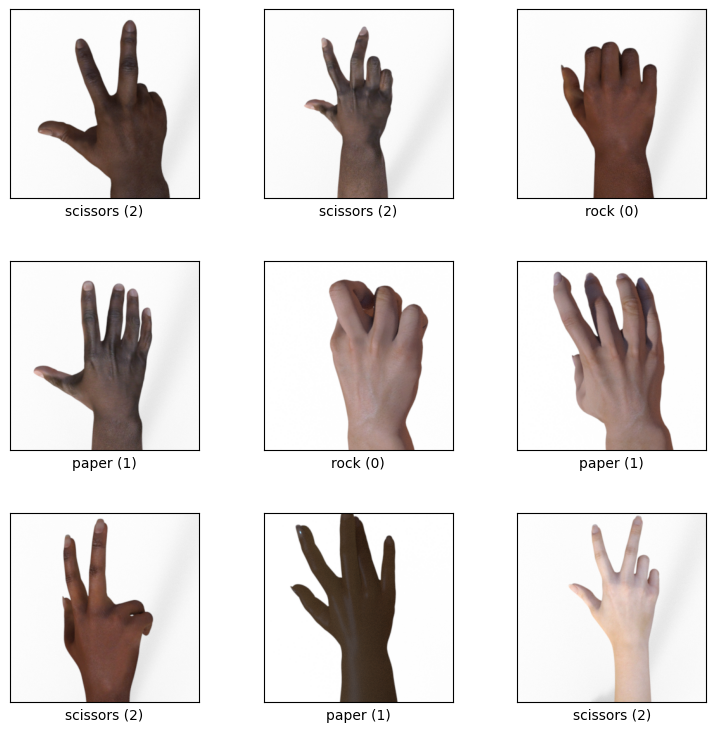

In [ ]:
fig = tfds.show_examples(info, ds_train)

### Data Prep

( tf format to numpy )

In [ ]:
#                                                 Every thing for first 2 dimentions but we care only about 1 color
train_images = np.array([example['image'].numpy()[:,:,0] for example in ds_train])
train_labels = np.array([example['label'].numpy() for example in ds_train])

test_images = np.array([example['image'].numpy()[:,:,0] for example in ds_test])
test_labels = np.array([example['label'].numpy() for example in ds_test])

In [ ]:
train_images = train_images.reshape(2520, 300, 300, 1)
test_images = test_images.reshape(372, 300, 300, 1)

# coverting to scale 0.0 - 1.0
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255
test_images /= 255

### Training basic model

In [ ]:
model = keras.Sequential([
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(3, activation='softmax') # when identifing just one label softmax is ok
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 68s 829ms/step - loss: 1.0749 - accuracy: 0.4250
Epoch 2/5
79/79 [==============================] - 75s 953ms/step - loss: 0.7836 - accuracy: 0.6889
Epoch 3/5
79/79 [==============================] - 66s 841ms/step - loss: 0.5624 - accuracy: 0.7730
Epoch 4/5
79/79 [==============================] - 68s 863ms/step - loss: 0.3681 - accuracy: 0.8798
Epoch 5/5
79/79 [==============================] - 67s 844ms/step - loss: 0.2664 - accuracy: 0.9202


In [ ]:
model.evaluate(test_images, test_labels)

12/12 [==============================] - 1s 102ms/step - loss: 1.5042 - accuracy: 0.4597


[1.5042442083358765, 0.45967742800712585]

### Convolutional Network

#### it makes a grid like thing on top of our image

<img src="https://miro.medium.com/v2/resize:fit:1400/1*_x133taVqLpW4zWJdLsu6Q.jpeg" width="650" />

In [ ]:
model = keras.Sequential([
   keras.layers.Conv2D(64, 3, activation='relu', input_shape=(300,300,1)),
   keras.layers.Conv2D(32, 3, activation='relu'),
   keras.layers.Flatten(),
   keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=32)

In [ ]:
model.evaluate(test_images, test_labels)

Better Convolutional Network

In [ ]:
# reduce size of input image before we start "convoluting" on it
model = keras.Sequential([
   keras.layers.AveragePooling2D(pool_size=(6,6), strides=3, input_shape=(300,300,1)), # on 300x300 image we put boxes aravarging box squares 6x6 pixels => image after this layer is 100x100
   keras.layers.Conv2D(64, 3, activation='relu'),
   keras.layers.Conv2D(32, 3, activation='relu'),
   keras.layers.MaxPool2D(2,2), # from each box 2x2 we take just max value
   keras.layers.Dropout(0.5), # dorp 50% of connections
   keras.layers.Flatten(),
   keras.layers.Dense(128, activation='relu'),
   keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=32)

Epoch 1/5
79/79 [==============================] - 136s 2s/step - loss: 0.9711 - accuracy: 0.6524
Epoch 2/5
79/79 [==============================] - 137s 2s/step - loss: 0.0797 - accuracy: 0.9825
Epoch 3/5
79/79 [==============================] - 133s 2s/step - loss: 0.0244 - accuracy: 0.9952
Epoch 4/5
79/79 [==============================] - 130s 2s/step - loss: 0.0093 - accuracy: 0.9992
Epoch 5/5
79/79 [==============================] - 130s 2s/step - loss: 0.0108 - accuracy: 0.9976


In [ ]:
model.evaluate(test_images,test_labels)

12/12 [==============================] - 5s 399ms/step - loss: 0.8716 - accuracy: 0.7258


[0.8715757131576538, 0.725806474685669]

# Hyperparameter Tuning

In [ ]:
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.8 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch

"""
  It's exactly the same base for the model we had earlier but using builer design patter.
  hp - hyper-parameter
  hp.Choice("Layer type/label", [ list of params we would like to consider ])
  same layers don't depend on params so we can simple hardcode the model.add( ... )
"""

def build_model(hp):
  model = keras.Sequential()

  model.add(keras.layers.AveragePooling2D(6,3,input_shape=(300,300,1)))

  for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
    model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
  
  model.add(keras.layers.MaxPool2D(2,2))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256, 512, 1024]), activation='relu'))

  model.add(keras.layers.Dense(3, activation='softmax'))

  model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
  
  return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=32,
)


<ipython-input-12-e15a9f5a2676>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# Running tuner

tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32)

Trial 7 Complete [00h 02m 21s]
val_accuracy: 0.6505376100540161

Best val_accuracy So Far: 0.7795698642730713
Total elapsed time: 01h 27m 49s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
2                 |1                 |Conv Layers
1024              |64                |Dense layer
32                |16                |layer_0_filters
32                |None              |layer_1_filters
16                |None              |layer_2_filters

Epoch 1/10
79/79 [==============================] - 190s 2s/step - loss: 0.9983 - accuracy: 0.7976 - val_loss: 0.7224 - val_accuracy: 0.6478
Epoch 2/10
79/79 [==============================] - 199s 3s/step - loss: 0.0219 - accuracy: 0.9960 - val_loss: 0.6921 - val_accuracy: 0.7285
Epoch 3/10
79/79 [==============================] - 186s 2s/step - loss: 0.0068 - accuracy: 0.9988 - val_loss: 0.7824 - val_accuracy: 0.7419
Epoch 4/10
79/79 [==============================] - 180s 2s/step - loss: 0.0026 - accuracy: 

KeyboardInterrupt: ignored

In [ ]:
# Out of all tried models get the best one
best_model = tuner.get_best_models()[0]

In [ ]:
# Check how the best model is doing
best_model.evaluate(test_images, test_labels)

In [ ]:
# Get info about best model parameters
best_model.summary()

In [ ]:
# More info on each parameter test
tuner.results_summary()

# Exporting And Importing model

In [ ]:
best_model.save('./my_model')

In [ ]:
loaded_model = keras.models.load_model('./my_model')

In [ ]:
loaded_model.evaluate(test_images, test_labels)

# Plot Image from Numpy

In [ ]:
rgb_images = np.array([example['image'].numpy() for example in ds_train.take(1)])
rgb_image = rgb_images[0]

image = train_images[0].reshape(300,300)

plt.imshow(rgb_image)

rgb_image.shape

# Convert PNG/JPG images to Numpy Format

In [ ]:
import imageio

im = imageio.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Massachusetts_State_House_-_panoramio_%281%29.jpg/280px-Massachusetts_State_House_-_panoramio_%281%29.jpg')

print(type(im))

plt.imshow(im)

im_np = np.asarray(im)

print(im_np.shape)

# Use Model to Predict Result for Single Example

In [ ]:
result = best_model.predict(np.array([train_images[0]]))
print(result)

predicted_value = np.argmax(result)
print(predicted_value)